<a href="https://colab.research.google.com/github/zhongjie-wu/579project/blob/main/Nash_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pettingzoo[mpe]

In [2]:
import warnings
warnings.filterwarnings("error")

In [3]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from pettingzoo.mpe import simple_speaker_listener_v3, simple_reference_v2, simple_world_comm_v2
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import tensorflow as tf
from collections import deque
import time
import random
from tqdm import tqdm
import os
from sklearn.preprocessing import StandardScaler
import json
import matplotlib.pyplot as plt

In [4]:
#Global Variables
DISCOUNT = 0.99
MINIBATCH_SIZE = 32  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)

# Environments
EPISODES = 100
MAX_CYCLES = 25

REPLAY_MEMORY_SIZE = int(EPISODES * MAX_CYCLES / 5)  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = int(REPLAY_MEMORY_SIZE / 5 /2)  # Minimum number of steps in a memory to start training

# Exploration settings
EPSILON = 0.1  # decaying epsilon
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.001

In [5]:
def eps_greedy_act_selection(epsilon, action_space_size, q_values):
    if np.random.random() < epsilon:
        # randomly choose one action
        return np.random.randint(0, action_space_size)
    else:
        # all q values
        return np.argmax(q_values)

def normalization(X):
        mu = np.mean(X, axis=0)
        sigma = np.std(X, axis=0)
    
        # Normalize the features using the mean and standard deviation
        X_norm = (X - mu) / sigma

        return X_norm

## Individual DQN

In [6]:
class DQNAgent:
    def __init__(self, input_layer_size, action_space_size):
        # Main model which we use to train
        self.model = self.create_model(input_layer_size, action_space_size)

        # Target network to make sure the updating is stable
        self.target_model = self.create_model(input_layer_size, action_space_size)
        self.target_model.set_weights(self.model.get_weights())

        # The array to keep the memory for the last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        # Count when to update target network with main network's weights
        self.target_update_counter = 0


    def create_model(self, input_layer_size, action_space_size):
        model = Sequential()
        model.add(Dense(64, activation='relu', input_shape=(input_layer_size,)))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(action_space_size, activation = 'linear'))
        model.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        return model

    def update_replay_memory(self, transition):
        # transition = (s, a, r, s', done)
        self.replay_memory.append(transition)


    def train(self, terminal_state):
        # Start training only if enough transition samples has been collected in the memory
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        # Get a minibatch from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get the current states and their corresponding q values for each sample in the minibatch
        current_states = np.array([transition[0] for transition in minibatch])
        # current_states = StandardScaler().fit_transform(current_states)
        current_qs_list = self.model.predict(current_states, verbose=0)

        # Get the next states their corresponding q values for each sample in the minibatch
        new_current_states = np.array([transition[3] for transition in minibatch])
        # new_current_states = StandardScaler().fit_transform(new_current_states)
        future_qs_list = self.target_model.predict(new_current_states, verbose=0)

        X = []
        y = []

        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward
            
            # Update Q value for the given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # Prepare training data
            X.append(current_state)
            y.append(current_qs)

        self.model.fit(np.array(X), np.array(y), batch_size=MINIBATCH_SIZE, shuffle=False, verbose=0)

        if terminal_state:
            self.target_update_counter += 1
        
        # update target network with weights of main network if condition satisfied
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

    # Queries main network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape), verbose=0)[0]

In [7]:
AGENT_NAMES = ['speaker_0', 'listener_0']
AGENT_INFOS = {
    name:
        {
            "state_space_size": 3 if name == 'speaker_0' else 11, 
            "action_space_size": 3 if name == 'speaker_0' else 5 
        } for name in AGENT_NAMES
}

def dqn_sl(epsilon, num_episode, max_cycles, env):
    # initialize DQNAgents for the listener / speaker
    all_dqn_agents = {name: DQNAgent(AGENT_INFOS[name]["state_space_size"], 
                                     AGENT_INFOS[name]["action_space_size"]) for name in AGENT_NAMES}
    
    all_rewards = {agent_name:[] for agent_name in AGENT_NAMES}
    
    for episode in tqdm(range(1, num_episode + 1), ascii=True, unit='episodes'):
    # for episode in range(num_episode):
        # initialize environment & reward
        env.reset()
        episode_agent_reward = {agent_name:0 for agent_name in AGENT_NAMES}
        
        for agent in env.agent_iter():
            # do not do step if terminated 
            if env.truncations[agent] == True or env.terminations[agent] == True:
                    env.step(None)
                    continue    
            # storing size of action and state (metadata about agent)
            agent_info = AGENT_INFOS[agent]
            # store the corresponding dqn agent (not the game agent, the agent that does dqn stuff)
            dqn_agent = all_dqn_agents[agent]
            # actual agent living in environment
            game_agent_cur_state = env.observe(agent)
            
            game_agent_q_val = dqn_agent.get_qs(game_agent_cur_state)
            game_agent_action_size = agent_info["action_space_size"]
            action_taken = eps_greedy_act_selection(epsilon, game_agent_action_size, game_agent_q_val)
            
            # take the action choosen from eps greedy
            env.step(action_taken)
            
            # get reward and accumulate it
            _, R, termination, truncation, info = env.last()
            done = termination or truncation
            episode_agent_reward[agent] += R
            
            # get next state S'
            game_agent_next_state = env.observe(agent)
            
            # update replay memory, and train if we have enough replay memory
            dqn_agent.update_replay_memory((game_agent_cur_state, action_taken, R, game_agent_next_state, done))
            dqn_agent.train(done)
        
        # store the total rewards for last game play in one episode
        for name in AGENT_NAMES:
            all_rewards[name].append(episode_agent_reward[name]/max_cycles)

        if epsilon > MIN_EPSILON:
            epsilon *= EPSILON_DECAY
            epsilon = max(MIN_EPSILON, epsilon)
             
    return all_rewards

# Returns a initialized weight vector with 0
def rand_sl(num_episode, max_cycles,  env):
    all_rewards = {agent_name:[] for agent_name in AGENT_NAMES}
    
    for i in range(num_episode):
        env.reset()
        episode_agent_reward = {agent_name:0 for agent_name in AGENT_NAMES}
        for agent in env.agent_iter():
            if env.truncations[agent] == True or env.terminations[agent] == True:
                env.step(None)
                continue
            
            A = env.action_space(agent).sample()

            env.step(A)
            _, R, termination, truncation, info = env.last()
            episode_agent_reward[agent] += R

            if termination or truncation:
                continue
            
        # store the total rewards for last game play in one episode
        for name in AGENT_NAMES:
            all_rewards[name].append(episode_agent_reward[name]/max_cycles)
    return all_rewards

## Nash DQN

In [8]:
LAMBDA_NASH = 0.3

In [9]:
class NashDQNAgent:
    def __init__(self, agent_idx, input_layer_size, action_space_size, num_agents):
        self.agent_idx = agent_idx #Assume that idx 0 is speaker and 1 is listener
        self.input_layer_size = input_layer_size
        self.action_space_size = action_space_size
        self.num_agents = num_agents
        
        # Create the main model used for training
        self.model = self.create_model()

        # Create the target model used for updating the main model
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        # Initialize the replay memory
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        # Counter for updating the target model
        self.target_update_counter = 0


    def create_model(self):
        model = Sequential()
        model.add(Dense(64, activation='relu', input_shape=(self.input_layer_size,)))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_space_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        return model


    def update_replay_memory(self, transition):
        # Add the transition to the replay memory buffer
        self.replay_memory.append(transition)

    def get_qs(self, state):
        # the model takes in a full state (14 = 11 + 3)
        return self.model.predict(np.array(state).reshape(-1, *state.shape), verbose=0)[0]

    def get_nash_q(self, state):
        # Compute the Nash Q values for both agents given the current state
        agent_qs = self.model.predict(state.reshape(-1, *state.shape), verbose=0)[0]
        other_agent_qs = np.zeros((self.action_space_size,))
        
        for i in range(self.num_agents):
            if i != self.agent_idx:
                other_agent_qs += self.model.predict(state.reshape(-1, *state.shape), batch_size=1, verbose=0)[0]

        nash_qs = np.zeros((self.action_space_size,))

        for action in range(self.action_space_size):
            nash_qs[action] = agent_qs[action] + (other_agent_qs.max() - other_agent_qs[action]) / (self.num_agents - 1)

        return nash_qs


    def train(self, terminal_state):
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        # Sample a minibatch from the replay memory
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Compute the current Q values for the agent's actions in the minibatch
        full_states = np.array([transition[0] for transition in minibatch])
        current_states = full_states
        if self.agent_idx == 0:
            current_states[:, -11:] = 0
        else:
            current_states[:, :3] = 0
        current_qs_list = self.model.predict(current_states, verbose=0)

        # Compute the next Q values for the agent's actions in the minibatch
        full_new_current_states = np.array([transition[3] for transition in minibatch])
        new_current_states = full_new_current_states
        if self.agent_idx == 0:
            new_current_states[:, -11:] = 0
        else:
            new_current_states[:, :3] = 0
        future_qs_list = self.target_model.predict(new_current_states, verbose=0)

        X = []
        y = []

        for index, (full_current_state, actions, rewards, _, all_done_states) in enumerate(minibatch):
            # Compute the Nash Q value for the current state
            # nash_qs = self.get_nash_q(full_current_state)
            done = all_done_states[self.agent_idx]
            reward = rewards[self.agent_idx]
            action = actions[self.agent_idx]

            if not done:
                # Compute the target Q value using the Nash Q values
                tmp_full_current_state = full_current_state[:,None].reshape((1,14))
                max_future_q = np.max(self.target_model.predict(tmp_full_current_state, verbose=0))
                new_q = reward + DISCOUNT * max_future_q
                # new_q = reward + DISCOUNT * max_future_q
                # nash_q_diff = abs(current_qs_list[index] - nash_qs) * LAMBDA_NASH
                # new_q = (1 - LAMBDA_NASH) * new_q + nash_q_diff
            else:
                new_q = reward
            
            # Update Q value for the given state and action
            
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # Prepare training data
            X.append(full_current_state)
            y.append(current_qs)

        # Fit the model using the minibatch
        self.model.fit(np.array(X), np.array(y), batch_size=MINIBATCH_SIZE, shuffle=False, verbose=0)

        if terminal_state:
            self.target_update_counter += 1
        
        # Update target network with weights of main network if condition satisfied
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

In [10]:

def nash_dqn_sl(epsilon, num_episode, max_cycles, env):
    AGENT_NAMES = ['speaker_0', 'listener_0']
    AGENT_INFOS = {name: {"agent_idx": 0 if name == 'speaker_0' else 1,
                          "action_space_size": 3 if name == 'speaker_0' else 5
                          } for name in AGENT_NAMES}
    NASH_DQN_AGENTS = {name: NashDQNAgent(AGENT_INFOS[name]["agent_idx"], 14,
                                          AGENT_INFOS[name]["action_space_size"], 2) for name in AGENT_NAMES}
    UPDATE_COUNTER = 0
    ALL_REWARDS = {agent_name:[] for agent_name in AGENT_NAMES}
    
    for episode in tqdm(range(1, num_episode + 1), ascii=True, unit='episodes'):
        # for episode in range(num_episode):
        # initialize environment & reward
        env.reset()
        episode_agent_reward = {agent_name:0 for agent_name in AGENT_NAMES}
        full_state = []
        full_next_state = []
        rewards = []
        actions = [] 
        all_done_states = []
        
        for agent in env.agent_iter():
            # storing size of action and state (metadata about agent)
            agent_info = AGENT_INFOS[agent]
            # do not do step if terminated 
            if env.truncations[agent] == True or env.terminations[agent] == True:
                env.step(None)
                continue

            # store the corresponding dqn agent (not the game agent, the agent that does dqn stuff)
            nash_dqn_agent = NASH_DQN_AGENTS[agent]
            # actual agent living in environment
            game_agent_cur_state = env.observe(agent)
            
            # append to form a full state WITHOUT PADDING
            full_state.append(game_agent_cur_state)

            # need to perform a padding to current agent state
            #speaker, append 11 0's at the end
            if agent_info["agent_idx"] == 0: 
                masked_game_agent_cur_state = np.concatenate((np.array(game_agent_cur_state), np.zeros(11)))
            else:
                masked_game_agent_cur_state = np.concatenate((np.zeros(3), game_agent_cur_state))
                
            game_agent_q_val = nash_dqn_agent.get_qs(masked_game_agent_cur_state)
            game_agent_action_size = agent_info["action_space_size"]
            action_taken = eps_greedy_act_selection(epsilon, game_agent_action_size, game_agent_q_val)
            actions.append(action_taken)
            # take the action choosen from eps greedy
            env.step(action_taken)
            
            # get reward and accumulate it
            _, R, termination, truncation, info = env.last()
            episode_agent_reward[agent] += R
            rewards.append(R)
            done = termination or truncation
            all_done_states.append(done)
            
            game_agent_next_state = env.observe(agent)
            full_next_state.append(game_agent_next_state)
            UPDATE_COUNTER += 1
            
            
            if UPDATE_COUNTER == 2:
                # for plotting
                for idx in range(len(AGENT_NAMES)):
                    name = AGENT_NAMES[idx]
                    combined_full_state = np.concatenate(full_state)
                    combined_full_next_state = np.concatenate(full_next_state)
                    trainsition = (combined_full_state, actions, rewards, combined_full_next_state, all_done_states)
                    nash_dqn_agent = NASH_DQN_AGENTS[name]
                    nash_dqn_agent.update_replay_memory(trainsition)
                    done_state = all_done_states[idx]
                    
                    # with open("test.log", "a") as f:
                    #     f.write(f"episode: {episode}, ")
                    #     f.write(f"replay memory size: {len(nash_dqn_agent.replay_memory)}\n")
                    
                    nash_dqn_agent.train(done_state)
                
                # clear it
                full_state = []
                full_next_state = []
                rewards = []
                actions = [] 
                all_done_states = []
                UPDATE_COUNTER = 0
        # store the total rewards for last game play in one episode
        for name in AGENT_NAMES:
            ALL_REWARDS[name].append(episode_agent_reward[name]/max_cycles)
        
        if epsilon > MIN_EPSILON:
            epsilon *= EPSILON_DECAY
            epsilon = max(MIN_EPSILON, epsilon)
             
    return ALL_REWARDS

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



100%|##########| 100/100 [1:21:36<00:00, 48.96s/episodes]


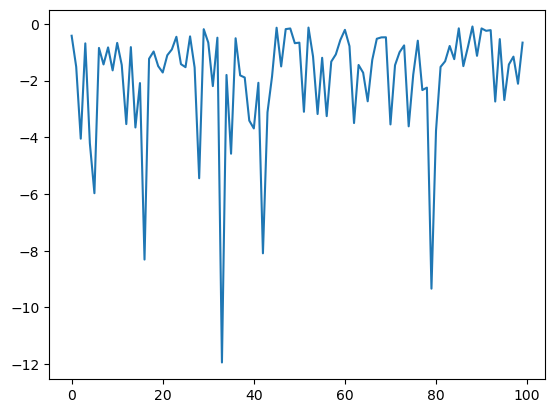

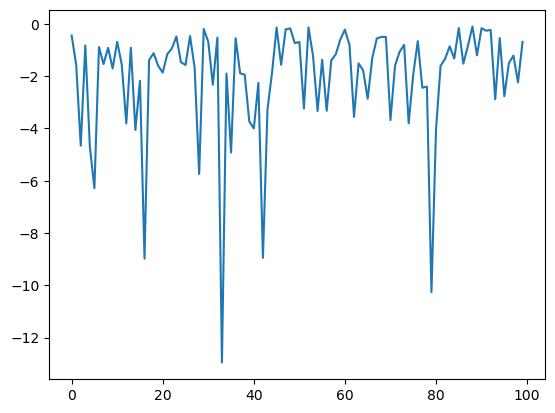

In [11]:
env = simple_speaker_listener_v3.env(max_cycles=MAX_CYCLES, continuous_actions=False)
nash_dqn_rewards = nash_dqn_sl(EPSILON, EPISODES, MAX_CYCLES, env)

with open(f"nash_dqn_data_ep{EPISODES}_cycles_{MAX_CYCLES}.json", "w") as f:
    # store the experiement result
    json.dump(nash_dqn_rewards, f)

plt.plot(range(EPISODES), nash_dqn_rewards['speaker_0'])
plt.show()

plt.plot(range(EPISODES), nash_dqn_rewards['listener_0'])
plt.show()

In [19]:
print(np.mean(nash_dqn_rewards['listener_0'][:50]))
print(np.mean(nash_dqn_rewards['listener_0'][-50:]))
print(np.mean(nash_dqn_rewards['listener_0']))


-2.3972700010623345
-1.6818496101893212
-2.0395598056258275


In [20]:
print(np.mean(nash_dqn_rewards['speaker_0'][:50]))
print(np.mean(nash_dqn_rewards['speaker_0'][-50:]))
print(np.mean(nash_dqn_rewards['speaker_0']))

-2.2250334812524626
-1.592573243458772
-1.9088033623556173
